In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

event_id = os.getcwd().split('/')[-3]
print(f'EVENT: {event_id}')

base_dir = f"/data/des70.a/data/desgw/O4/{event_id}/gw_workflow/"

with open(base_dir+'dagmaker.rc') as rcfile:
    for line in rcfile.readlines():
        if 'SEASON' in line:
            season = int(line[-5:-1])
            print(f'SEASON: {season}')

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

<h2>Finding Exposures</h2>

In [2]:
search_expnums = []
for filename in glob(base_dir+f'../exposures/*/{event_id}_exposures.list'):
    search_expnums = np.append(search_expnums, np.loadtxt(filename))
search_expnums = np.unique(search_expnums).astype(int)

search_commands = []
search_bands = []
serial_commands = []
search_nites = []
for expnum in search_expnums:
    with open(base_dir+f'desgw_pipeline_{expnum}.dag') as dagfile:
        p_counter = 0
        s_counter = 0
        for i, line in enumerate(dagfile):
            if line.strip()=='<parallel>' or line.strip()=='</parallel>':
                p_counter += 1
            elif line.strip()=='<serial>':
                s_counter += 1
            elif p_counter==3:
                search_nites.append(line.split()[32])
                search_bands.append(line.split()[30])
                search_commands.append(line)
                p_counter += 1
            elif s_counter==1:
                serial_commands.append(line)
print('Total Search Images:', len(search_expnums))

Total Search Images: 297


In [3]:
template_expnums = []
template_commands = []
template_nites = []

for expnum in search_expnums:
    with open(base_dir+f'desgw_pipeline_{expnum}.dag') as dagfile:
        for i, line in enumerate(dagfile):
            if i<2:
                continue
            if line.strip()=='</parallel>':
                break
            template_nites.append(line.split()[37])
            template_expnums.append(line.split()[31])
            template_commands.append(line)

print('Total Templates:', len(template_expnums))
template_expnums, unique_idx = np.unique(template_expnums, return_index=True)
template_commands = np.array(template_commands)[unique_idx]
template_nites = np.array(template_nites)[unique_idx]
print('Unique Templates:', len(template_expnums))

Total Templates: 14689
Unique Templates: 1638


<h2>Incorrectly Calibrated Exposures</h2>

In [4]:
# TEMPLATES
last_mod_sediff_time = os.path.getmtime(base_dir+'SEdiff.sh')
last_mod_sediff_time = 1722870670.967716 # 05.08.2024 last dagmaker change, safe for calibration

n_templates = len(template_expnums)
failexp = 0
fail_idxs = []
fail_ccds = []
totalfailccd = 0
for i in range(n_templates):
    path = '/pnfs/des/persistent/gw/exp/{}/{}/'.format(template_nites[i], template_expnums[i])
    failccd = 0
    for file in glob(path+'*r4p12_ZP.csv'):
        if os.path.getmtime(file) < last_mod_sediff_time:
            fail_ccds.append([template_expnums[i], template_commands[i].split(' -b ')[1][0], template_nites[i], int(file.split('_')[1])])
            failccd += 1
    if failccd > 0:
        fail_idxs.append(i)
        #print('Exposure Number {}: '.format(template_expnums[i]), end='')
        #print(failccd)
        failexp += 1
    totalfailccd += failccd
print('Total Problem Templates: {}/{} ({:.1%})'.format(failexp, n_templates, failexp/n_templates))
print('Total Problem CCDs: {}/{} ({:.1%})'.format(totalfailccd, n_templates*60, totalfailccd/(n_templates*60)))

Total Problem Templates: 15/1638 (0.9%)
Total Problem CCDs: 15/98280 (0.0%)


In [5]:
# SEARCH
last_mod_sediff_time = os.path.getmtime(base_dir+'SEdiff.sh')
last_mod_sediff_time = 1722870670.967716 # 05.08.2024 last dagmaker change, safe for calibration

n_images = len(search_nites)
failexp = 0
search_fail_idxs = []
totalfailccd = 0
for i in range(len(search_nites)):
    path = '/pnfs/des/persistent/gw/exp/{}/{}/'.format(search_nites[i], search_expnums[i])
    failccd = 0
    for file in glob(path+'*r4p12_ZP.csv'):
        if os.path.getmtime(file) < last_mod_sediff_time:
            failccd += 1
    if failccd > 0:
        search_fail_idxs.append(i)
        #print('Exposure Number {}: '.format(template_expnums[i]), end='')
        #print(failccd)
        failexp += 1
    totalfailccd += failccd
print('Total Problem Search Images: {}/{} ({:.1%})'.format(failexp, n_images, failexp/n_images))
print('Total Problem CCDs: {}/{} ({:.1%})'.format(totalfailccd, n_images*60, totalfailccd/(n_images*60)))

Total Problem Search Images: 23/293 (7.8%)
Total Problem CCDs: 1043/17580 (5.9%)


In [6]:
search_fail_expnums = np.sort(np.array(search_expnums)[search_fail_idxs])
for i in search_fail_expnums:
    print(i)

1297759
1297761
1297762
1297763
1297765
1297767
1297768
1297770
1297771
1297772
1297773
1297774
1297775
1297776
1297778
1297785
1297786
1297787
1297789
1297790
1297791
1297792
1297793


<h2>Making Template DAGs</h2>

In [5]:
# FIRST PASS
njobs = 60
file_idx = 0

for i, command in enumerate(template_commands):
    if i%njobs==0:
        with open(base_dir+'template_pass0_{:03d}.dag'.format(file_idx), 'w') as outfile:
            outfile.write('<parallel>\n')
            outfile.write('jobsub -n --group=des --memory=500MB --disk=100MB --expected-lifetime=600s file://dummyjob.sh\n')
            for j in range(njobs):
                try:
                    command_edit = template_commands[i+j].strip().replace(' -j ', '  ').replace('--memory=2500MB', '--memory=4000MB')
                    outfile.write(command_edit+' -O \n')
                except:
                    break
            outfile.write('</parallel>')
        file_idx += 1

In [5]:
# SECOND PASS FOR EXPOSURES WITH FAILED CCDS
njobs = 60
file_idx = 0

for i in range(len(fail_idxs)):
    if i%njobs==0:
        with open(base_dir+'template_pass1_{:03d}.dag'.format(file_idx), 'w') as outfile:
            outfile.write('<parallel>\n')
            outfile.write('jobsub -n --group=des --memory=500MB --disk=100MB --expected-lifetime=600s file://dummyjob.sh\n')
            for j in range(njobs):
                try:
                    command_edit = template_commands[fail_idxs[i+j]].strip().replace(' -j ', '  ').replace('--memory=2500MB', '--memory=6000MB')
                    outfile.write(command_edit+' -O \n')
                except:
                    break
            outfile.write('</parallel>')
        file_idx += 1

In [6]:
# EXTRA PASSES FOR EXPOSURES WITH FAILED CCDS, CCD-WISE

with open(base_dir+'template_pass2.dag', 'w') as outfile:
    outfile.write('<parallel>\n')
    outfile.write('jobsub -n --group=des --memory=500MB --disk=100MB --expected-lifetime=600s file://dummyjob.sh\n')
    for i in range(len(fail_ccds)):
        command = "jobsub -n --group=des --singularity-image /cvmfs/singularity.opensciencegrid.org/fermilab/fnal-wn-sl7:latest --memory=32000MB --disk=70GB --cpu=1 --expected-lifetime=5h --email-to=alyssag94@brandeis.edu --disk=70GB --need-storage-modify /des/persistent/gw/exp --need-storage-modify /des/persistent/gw/forcephoto -e GFAL_PLUGIN_DIR=/usr/lib64/gfal2-plugins -e GFAL_CONFIG_DIR=/etc/gfal2.d --lines='+FERMIHTC_AutoRelease=True' --lines='+FERMIHTC_GraceLifetime=43200' --lines='+FERMIHTC_GraceMemory=5000' --append_condor_requirements='(TARGET.GLIDEIN_Site==\"FermiGrid\"||(TARGET.HAS_SINGULARITY==true&&TARGET.HAS_CVMFS_des_opensciencegrid_org==true&&TARGET.HAS_CVMFS_des_osgstorage_org==true))' file://SEdiff.sh -r 4 -p 12 -E {} -v gw8 -b {} -n {} -d persistent -m gw -c {} -C -t -S dp{} -O \n".format(*fail_ccds[i], season)
        outfile.write(command)
    outfile.write('</parallel>')

In [ ]:
# EXTRA PASSES FOR EXPOSURES WITH FAILED CCDS (ONLY ONES THAT EXIST IN PNFS)
njobs = 60
file_idx = 0

for i in range(len(fail_idxs)):
    if i%njobs==0:
        with open(base_dir+'template_pass5_{:03d}.dag'.format(file_idx), 'w') as outfile:
            outfile.write('<parallel>\n')
            outfile.write('jobsub -n --group=des --memory=500MB --disk=100MB --expected-lifetime=600s file://dummyjob.sh\n')
            for j in range(njobs):
                try:
                    command_edit = template_commands[fail_idxs[i+j]].strip().replace(' -j ', '  ').replace('--memory=2500MB', '--memory=6000MB')
                    outfile.write(command_edit+' -O \n')
                except:
                    break
            outfile.write('</parallel>')
        file_idx += 1

<h2>Running Searches as Templates for SE Processing</h2>

In [9]:
# FIRST PASS FOR SEARCH SE PROCESSING

njobs = 60
file_idx = 0

for i in range(len(search_expnums)):
    if i%njobs==0:
        with open(base_dir+'search_pass0_{:03d}.dag'.format(file_idx), 'w') as outfile:
            outfile.write('<parallel>\n')
            outfile.write('jobsub -n --group=des --memory=500MB --disk=100MB --expected-lifetime=600s file://dummyjob.sh\n')
            for j in range(njobs):
                try:
                    command = "jobsub -n --group=des --singularity-image /cvmfs/singularity.opensciencegrid.org/fermilab/fnal-wn-sl7:latest --memory=4000MB --disk=70GB --cpu=1 --expected-lifetime=5h --email-to=alyssag94@brandeis.edu --disk=70GB --need-storage-modify /des/persistent/gw/exp --need-storage-modify /des/persistent/gw/forcephoto -e GFAL_PLUGIN_DIR=/usr/lib64/gfal2-plugins -e GFAL_CONFIG_DIR=/etc/gfal2.d --lines='+FERMIHTC_AutoRelease=True' --lines='+FERMIHTC_GraceLifetime=43200' --lines='+FERMIHTC_GraceMemory=5000' -N 60 --append_condor_requirements='(TARGET.GLIDEIN_Site==\"FermiGrid\"||(TARGET.HAS_SINGULARITY==true&&TARGET.HAS_CVMFS_des_opensciencegrid_org==true&&TARGET.HAS_CVMFS_des_osgstorage_org==true))' file://SEdiff.sh -r 4 -p 12 -E {} -v gw8 -b {} -n {} -d persistent -m gw -c 0 -C -t -S dp{} -O \n".format(search_expnums[i+j], search_bands[i+j], search_nites[i+j], season)
                    outfile.write(command)
                except:
                    break
            outfile.write('</parallel>')
        file_idx += 1

In [8]:
# SECOND PASS FOR SEARCH SE PROCESSING

njobs = 60
file_idx = 0

for i in range(len(np.array(search_expnums)[search_fail_idxs])):
    if i%njobs==0:
        with open(base_dir+'search_pass1_{:03d}.dag'.format(file_idx), 'w') as outfile:
            outfile.write('<parallel>\n')
            outfile.write('jobsub -n --group=des --memory=500MB --disk=100MB --expected-lifetime=600s file://dummyjob.sh\n')
            for j in range(njobs):
                try:
                    command = "jobsub -n --group=des --singularity-image /cvmfs/singularity.opensciencegrid.org/fermilab/fnal-wn-sl7:latest --memory=4000MB --disk=70GB --cpu=1 --expected-lifetime=5h --email-to=alyssag94@brandeis.edu --disk=70GB --need-storage-modify /des/persistent/gw/exp --need-storage-modify /des/persistent/gw/forcephoto -e GFAL_PLUGIN_DIR=/usr/lib64/gfal2-plugins -e GFAL_CONFIG_DIR=/etc/gfal2.d --lines='+FERMIHTC_AutoRelease=True' --lines='+FERMIHTC_GraceLifetime=43200' --lines='+FERMIHTC_GraceMemory=5000' -N 60 --append_condor_requirements='(TARGET.GLIDEIN_Site==\"FermiGrid\"||(TARGET.HAS_SINGULARITY==true&&TARGET.HAS_CVMFS_des_opensciencegrid_org==true&&TARGET.HAS_CVMFS_des_osgstorage_org==true))' file://SEdiff.sh -r 4 -p 12 -E {} -v gw8 -b {} -n {} -d persistent -m gw -c 0 -C -t -S dp{} -O \n".format(np.array(search_expnums)[search_fail_idxs][i+j], np.array(search_bands)[search_fail_idxs][i+j], np.array(search_nites)[search_fail_idxs][i+j], season)
                    outfile.write(command)
                except:
                    break
            outfile.write('</parallel>')
        file_idx += 1

<h2>Post Processing Analysis</h2>

In [7]:
search_failfiles = []
search_outfiles = []
failtype = []
for i in range(len(search_expnums)):
    list_outfiles = glob(f'/pnfs/des/persistent/gw/exp/{search_nites[i]}/{search_expnums[i]}/dp{season}/*/*.gz')
    if len(list_outfiles) > 0:
        search_outfiles.append(len(list_outfiles))
        list_failfiles = glob(f'/pnfs/des/persistent/gw/exp/{search_nites[i]}/{search_expnums[i]}/dp{season}/*/*.FAIL')
        for i in range(len(list_failfiles)):
            failtype.append(list_failfiles[i].split('/')[-1].split('_')[0])
        if len(list_failfiles) > 0:
            search_failfiles.append(len(list_failfiles))
        else:
            search_failfiles.append(0)
    else:
        search_outfiles.append(0)
        search_failfiles.append(0)

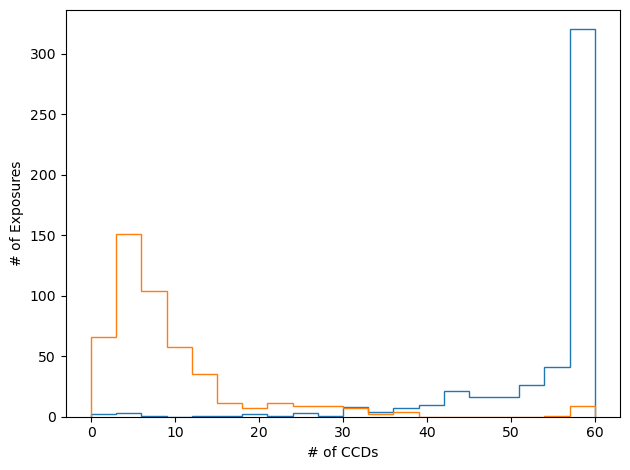

In [8]:
fig, ax = plt.subplots()
ax.hist(search_outfiles, bins=20, range=(0, 60), histtype='step', label='Output Files')
ax.hist(search_failfiles, bins=20, range=(0, 60), histtype='step', label='Fail Files')
ax.set_xlabel('# of CCDs')
ax.set_ylabel('# of Exposures')
fig.tight_layout()

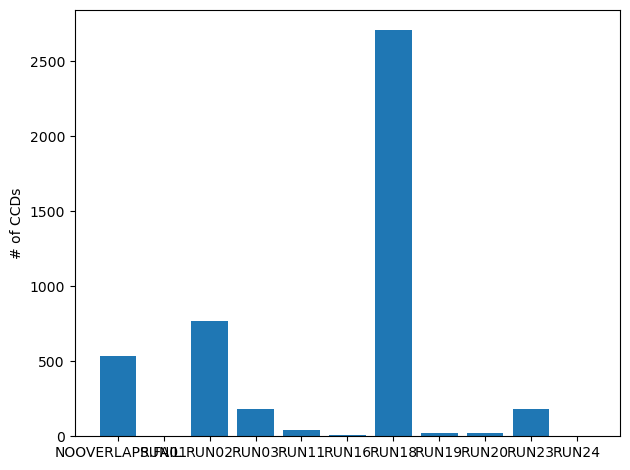

In [9]:
failnames, failnums = np.unique(failtype, return_counts=True)

fig, ax = plt.subplots()
ax.bar(failnames, failnums)
ax.set_ylabel('# of CCDs')
fig.tight_layout()

In [10]:
print('{:.0%} output rate, {:.0%} fail rate, {:.0%} success rate'.format(
    np.sum(search_outfiles)/(np.max(search_outfiles)*len(search_outfiles)),
    np.sum(search_failfiles)/(np.max(search_outfiles)*len(search_outfiles)),
    (np.sum(search_outfiles)-np.sum(search_failfiles))/(np.max(search_outfiles)*len(search_outfiles)))) 

91% output rate, 16% fail rate, 76% success rate
